In [28]:
library(callr)
library(dplyr)
library(forcats)
library(ggplot2)
library(MatrixGenerics)
library(Seurat)
library(tibble)

In [96]:
pdfFonts(sans = pdfFonts()$Helvetica)
postscriptFonts(sans = postscriptFonts()$Helvetica)

ggplot2::theme_set(
  ggplot2::theme_bw() +
    ggplot2::theme(
      axis.text = element_text(color = "#000000"),
      legend.position = "none",
      panel.background = element_rect(fill="transparent"),
      # We want the facet text to appear as a title of the graphic. Not as a
      # detail akin to the axis break labels!
      strip.text = element_text(size = rel(1.2))
    )
)

In [2]:
metadata <- as_tibble(read.csv("../scRNA-seq-Metadata.csv"))
gtf <- as_tibble(read.csv("../scRNA-seq-Assay-Metadata.csv"))
with(metadata, table(batch, ident))

       ident
batch   germline muscle somatic somaticprecursor spermatocyte
  nos.1     2407     84    1682              193          249
  nos.2     5568     84    3157              178          106
  tj.1      1119     83    1885               60           94
  tj.2      1795     78    1537               84          175

In [3]:
dim(gtf)

[1] 17558    10

In [4]:
percentage_expression <- function(seurat, features, group.by = "ident") {
    DefaultAssay(seurat) <- "RNA"
    data <- FetchData(seurat, c(group.by, features), layer = "counts")
    data <- data[, -1] %>% split(pull(data, 1))
    sapply(data, \(df) colMeans(apply(df, 2, \(v) v != 0)))
}

In [5]:
filenames <- c(
  nos.1="Nos-Upd_H3-GFP_Rep1",
  nos.2="Nos-Upd_H3-GFP_Rep2",
  tj.1="Tj-Upd_H3-GFP_Rep1",
  tj.2="Tj-Upd_H3-GFP_Rep2"
)
process_seurat <- function(name, filename_pattern) {
    library(dplyr)
    library(forcats)
    library(MatrixGenerics)
    library(Seurat)
    library(tibble)
    percentage_expression <- function(seurat, features, group.by = "ident") {
        DefaultAssay(seurat) <- "RNA"
        data <- FetchData(seurat, c(group.by, features), layer = "counts")
        data <- data[, -1] %>% split(pull(data, 1))
        sapply(data, \(df) colMeans(apply(df, 2, \(v) v != 0)))
    }
    gtf <- as_tibble(read.csv("../scRNA-seq-Assay-Metadata.csv"))
    filename <- paste0("../scRNA-seq/", filename_pattern, "/outs/filtered_feature_bc_matrix")
    # 1: Read and process ALL cells called by 10X Cell Ranger.
    counts <- filename %>% Read10X()
    rownames(counts) <- gtf$X
    seurat <- counts %>% CreateSeuratObject()
    seurat <- seurat %>% RenameCells(add.cell.id = name)
    seurat$batch <- setNames(name, NULL)
    seurat$pct.mito <- seurat %>%
        PercentageFeatureSet(features = subset(rownames(seurat), gtf$chr == "mitochondrion_genome"))
    seurat <- seurat %>%
        SCTransform(
            vst.flavor = "v2",
            do.correct.umi = FALSE,
            verbose = FALSE,
            vars.to.regress = "pct.mito"
        )
    seurat <- seurat %>% RunPCA(verb = F) %>% FindNeighbors(dims = 1:8) %>% FindClusters(res = 1.5)
    # 2: Remove doublet clusters. If there is >50% expression of both a "GSC-only" and "CySC-only"
    # marker, then it is certain to be a doublet cluster. These clusters also tend to have excessively
    # high average nCount_RNA, so retaining those cells for now helped to pull in other doublet-like
    # cells.
    expr <- percentage_expression(seurat, c("vas", "lncRNA:roX2"))
    doublet_clusters <- names(which(colAlls(expr > 0.5)))
    seurat <- seurat %>% subset(idents = setdiff(levels(Idents(seurat)), doublet_clusters))
    # 3: Use an nUMI and nFeature filtering step that still retains most of the cells, but filters out
    # some of the cells that are dissimilar in their sequencing depth. This helps to cut down on the
    # number of resulting clusters which probably only differ in a technical aspect of num UMIs that
    # were called for the cell.
    # From our filter_integrate_data step.
    seurat <- seurat %>% subset(
        cells = Cells(seurat) %>%
            subset(
                between(seurat$nCount_RNA, 2200, 7500) &
                    between(seurat$nFeature_RNA, 500, 2500)
            )
    )
    # 4: Perform a PCA and clustering of cells passing QC.
    seurat <- seurat %>% RunPCA(verb = F) %>% FindNeighbors(dims = 1:7, nn.method = "rann") %>% FindClusters(res = 0.5)
    Idents(seurat) <- Idents(seurat) %>% fct_relabel(\(n) paste0(name, "_", n))
    DefaultAssay(seurat) <- "RNA"
    DietSeurat(seurat, assays = "RNA")
}
# Loading and filtering Seurat objects is a bit of a leaky process. The subprocess (callr)
# significantly improves our memory usage.
seurat <- apply(
    enframe(filenames),
    1,
    \(v) r(
        function(process_seurat, v) {
            process_seurat(v["name"], v["value"])
        },
        args = list(process_seurat, v)
    ),
    simplify=FALSE
)
seurat <- merge(seurat[[1]], seurat[-1])

In [8]:
seurat$selected_germline <- (
    metadata$ident[match(Cells(seurat), metadata$X)] == "germline"
) %>%
    replace(is.na(.), FALSE)
seurat$selected_somatic <- (
    metadata$ident[match(Cells(seurat), metadata$X)] == "somatic"
) %>%
    replace(is.na(.), FALSE)
table(seurat$selected_germline)


FALSE  TRUE 
16741 10720 

In [23]:
# 5: Propagate "germline" and "somatic" labels from our "good" 5-cluster model (which has
# pct.mito < 10) to the new clusters of each 10X batch.
pct.data <- percentage_expression(seurat, c("vas", "tj", "selected_germline", "selected_somatic"))
infer.ident <- setNames(
    ifelse(
        pct.data["selected_germline",, drop=T] >= 0.4 &
            pct.data["selected_somatic",, drop=T] < 0.01,
        "germline",
        ifelse(
            pct.data["selected_germline",, drop=T] < 0.01 &
                pct.data["selected_somatic",, drop=T] >= 0.4,
            "somatic",
            NA
        )
    ),
    levels(Idents(seurat))
)
# Print percent: Using our label propagation to new clusters, how many of the metadata "germline" and "somatic" (5 clusters model) did we recall?
c(
    mean(
        subset(
            Idents(seurat) %in% subset(names(infer.ident), infer.ident == "germline"),
            seurat$selected_germline
        ),
        na.rm=T
    ),
    mean(
        subset(
            Idents(seurat) %in% subset(names(infer.ident), infer.ident == "somatic"),
            seurat$selected_somatic
        ),
        na.rm=T
    )
)
Idents(seurat) <- Idents(seurat) %>%
    list() %>%
    append(
        subset(infer.ident, !is.na(infer.ident))
    ) %>%
    do.call(recode, .)
table(Idents(seurat))

[1] 0.9250933 0.9185095


germline  somatic  nos.1_7  nos.1_8  nos.1_9 nos.1_10 nos.1_11 nos.1_12 
   12514     9491      354      228      211       95       92       49 
 nos.2_7  nos.2_8  nos.2_9 nos.2_10   tj.1_6   tj.1_7   tj.1_8   tj.2_1 
     425      409       92       46      147       82       81     1079 
  tj.2_2   tj.2_3   tj.2_7   tj.2_8   tj.2_9  tj.2_10 
     765      687      294      120      109       91 

In [25]:
Idents(seurat, cells = Cells(seurat) %>% subset(seurat$selected_germline)) <- "germline"
Idents(seurat, cells = Cells(seurat) %>% subset(seurat$selected_somatic)) <- "somatic"
Idents(seurat) <- Idents(seurat) %>% relevel("germline")
table(Idents(seurat))


germline  somatic  nos.1_7  nos.1_8  nos.1_9 nos.1_10 nos.1_11 nos.1_12 
   13314    10136      303      207      211       89       92       10 
 nos.2_7  nos.2_8  nos.2_9 nos.2_10   tj.1_6   tj.1_7   tj.1_8   tj.2_1 
     237      377       92       46      102       82       81      686 
  tj.2_2   tj.2_3   tj.2_7   tj.2_8   tj.2_9  tj.2_10 
     310      620      209      120       51       86 

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


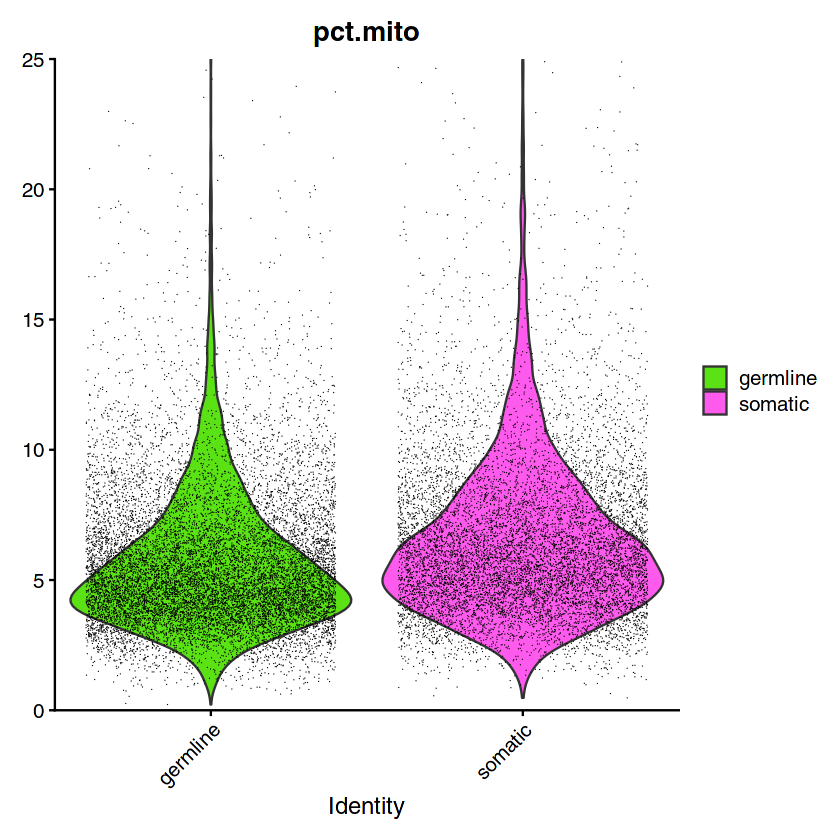

In [97]:
gg <- VlnPlot(
    seurat, 'pct.mito', idents=c('germline', 'somatic'),
    cols = c(hcl(123, 113, 80), "#FF5AEE")
)
gg[[1]]$layers[[2]]$aes_params$stroke <- NA
gg + coord_cartesian(c(0.5, 2.5), c(0, 25), expand=F)

In [44]:
args(density)

function (x, ...) 
NULL

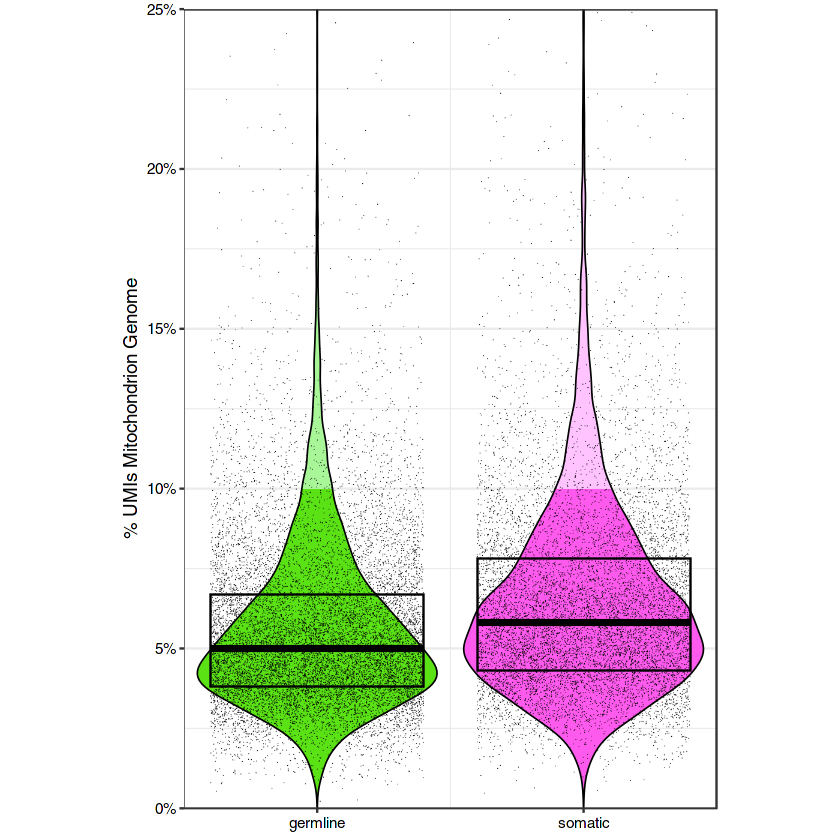

In [125]:
data <- FetchData(
    seurat, c("ident", "pct.mito")
) %>%
    subset(ident %in% c("germline", "somatic")) %>%
    group_by(ident) %>%
    reframe(
        x = seq(0, 100, by = 0.1) / 100,
        y = density(pct.mito, n = 100 / 0.1 + 1, from = 0, to = 100)$y %>%
            `*`(0.45 / max(.))
    )
density_quantile <- function(dens, q) {
    ecdf_values <- cumsum(dens) / sum(dens)
    unique(data$x)[findInterval(q, ecdf_values)]
}
ggplot(
    data,
    aes(y, x)
) +
    geom_polygon(
        aes(fill=ident),
        data %>%
            subset(x <= 0.1) %>%
            group_by(ident) %>%
            reframe(
                y = y %>% c(., -rev(.)) + as.numeric(ident[1]),
                x = x %>% c(., rev(.))
            )
    ) +
    geom_polygon(
        aes(fill=ident),
        data %>%
            subset(x >= 0.1) %>%
            group_by(ident) %>%
            reframe(
                y = y %>% c(., -rev(.)) + as.numeric(ident[1]),
                x = x %>% c(., rev(.)),
                ident = paste0(ident[1], ".muted"),
            )
    ) +
    geom_polygon(
        aes(group=ident),
        data %>%
            group_by(ident) %>%
            reframe(
                y = y %>% c(., -rev(.)) + as.numeric(ident[1]),
                x = x %>% c(., rev(.))
            ),
        fill = "transparent",
        color = "black",
        linewidth = 1 * 25.4 / 72
    ) +
    ggrastr::rasterise(
        geom_point(
            aes(),
            FetchData(seurat, c("ident", "pct.mito")) %>%
                subset(ident %in% c("germline", "somatic")) %>%
                tibble(
                    y = as.numeric(ident) - 0.4 + 0.8 * runif(n=length(ident)),
                    x = pct.mito / 100
                ),
            stroke = NA,
            size = 0.1
        ),
        dpi = 200
    ) +
    scale_x_continuous(
        breaks = c(1, 2),
        labels = c("germline", "somatic")
    ) +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_manual(
        values = c(hcl(123, 113, 80), "#FF5AEE") %>% c(scales::muted(., l=90))
    ) +
    annotate(
        "rect",
        xmin = c(0.6, 1.6),
        xmax = c(1.4, 2.4),
        ymin = split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.25)) %>% head(2) %>% unlist,
        ymax = split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.75)) %>% head(2) %>% unlist,
        fill = "transparent",
        color = "black"
    ) +
    annotate(
        "segment",
        x = c(0.6, 1.6),
        xend = c(1.4, 2.4),
        y = split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.5)) %>% head(2) %>% unlist,
        yend = split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.5)) %>% head(2) %>% unlist,
        color = "black",
        linewidth = 1.5
    ) +
    coord_cartesian(
        c(0.5, 2.5),
        c(0, 0.25),
        expand = FALSE
    ) +
    labs(x=NULL, y="% UMIs Mitochondrion Genome") +
    theme(aspect.ratio = 3/2)

In [80]:
split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.25)) %>% head(2) %>% unlist
split(data$y, data$ident) %>% sapply(purrr::partial(density_quantile, q=0.75)) %>% head(2) %>% unlist
quantile(seurat$pct.mito[Idents(seurat) == "germline"], c(0.25, 0.75))
quantile(seurat$pct.mito[Idents(seurat) == "somatic"], c(0.25, 0.75))

germline  somatic 
   0.038    0.043

germline  somatic 
   0.067    0.078

25%      75% 
3.895189 6.779995

25%      75% 
4.461646 7.885479

In [127]:
cairo_pdf("../figure/Integrated-scRNAseq/Pct-Mito.pdf", w=3, h=4.2)
print(last_plot())
dev.off()

png 
  2

In [131]:
FetchData(seurat, c("batch", "ident", "pct.mito")) %>%
    subset(as.numeric(ident) <= 2) %>%
    group_by(batch, ident) %>%
    summarise(median = median(pct.mito), .groups="drop")

batch,ident,median
<chr>,<fct>,<dbl>
nos.1,germline,4.880512
nos.1,somatic,6.223444
nos.2,germline,5.897065
nos.2,somatic,6.499089
tj.1,germline,4.427182
tj.1,somatic,5.142002
tj.2,germline,3.940677
tj.2,somatic,5.398981
